<h1><center> Energy Demand Forecasting </center></h1>

<img src="energy_demand.jpg" width="500" height="340"> 

<p><justify> In this project we are going to forecast the energy consumption using data from 2009 to 2022 collected hourly. Most of the project is based upon a Time Series Forecasting video by Rob Mulla in YouTube. We created datetime features and lag features to train a xgboost regressor. We use high-level plots from seaborn to show behaviour of the energy consumption for each datetime feature. We implemented the BlockTimeSeriesSplit method which splits the time series data respecting temporal order and preventing leakage from future data into the model. PyOD was also used to remove outliers from our data.</justify><p>

# Importing dataset and libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyod.models.ecod import ECOD

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error

import xgboost as xgb

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

Let's import the csv file containing historical data of energy demand in the UK data from 2009 to 2021

In [3]:
df = pd.read_csv('tsd_2009_2022h.csv')

In [4]:
df.head(5)

,settlement_date,tsd
0,2009-01-01 00:00:00,38704
1,2009-01-01 01:00:00,38651
2,2009-01-01 02:00:00,37298
3,2009-01-01 03:00:00,36844
4,2009-01-01 04:00:00,34635


Set the DataFrame index as the date

In [5]:
df = df.set_index('settlement_date')

Let's plot the Total System Demand (TSD) in MW during the entire dataset

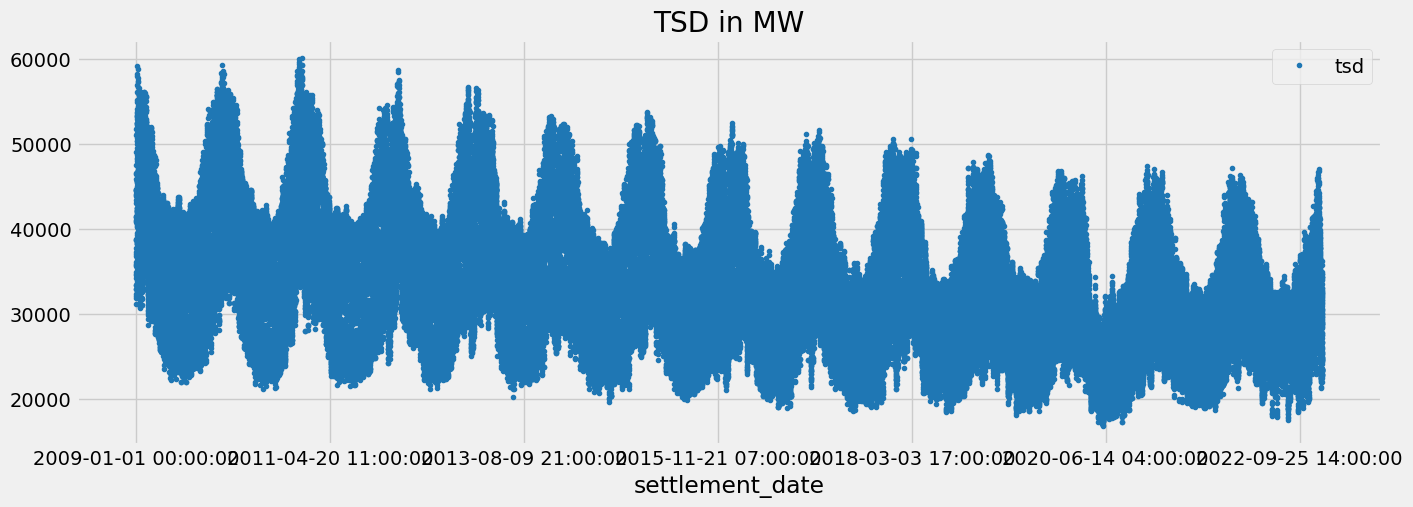

In [6]:
df.plot(style='.',figsize=(15,5),title='TSD in MW',color=color_pal[0])
plt.show()

Convert the index column to a datetime object

In [7]:
df.index = pd.to_datetime(df.index)

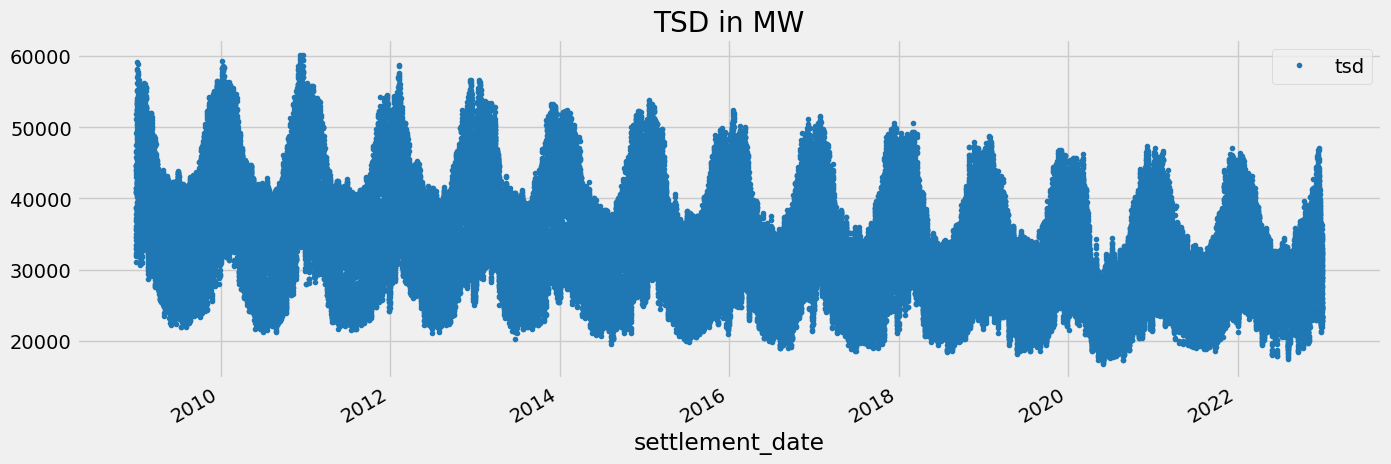

In [8]:
df.plot(style='.',figsize=(15,5),title='TSD in MW',color=color_pal[0])
plt.show()

# Feature Engineering

Let's create new features from the datetime column using the different properties of datetime objects.  

In [9]:
def create_datetime_feat(df):
    df = df.copy()
    df['hour']=df.index.hour
    df['dayofweek']=df.index.dayofweek
    df['quarter']=df.index.quarter
    df['month']=df.index.month
    df['year']=df.index.year
    df['dayofyear']=df.index.dayofyear
    df['dayofmonth']=df.index.day
    return df

In [10]:
df = create_datetime_feat(df)

We will also create lag features. Lag features are values at prior timesteps that are considered useful because they are created assuming that what happened in the past can contain information about the future.

In [11]:
def create_lag_feat(df):
    df = df.copy()
    target_map = df['tsd'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [12]:
df = create_lag_feat(df)

In [13]:
df

,tsd,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,lag1,lag2,lag3
settlement_date,,,,,,,,,,,
2009-01-01 00:00:00,38704,0,3,1,1,2009,1,1,NaN,NaN,NaN
2009-01-01 01:00:00,38651,1,3,1,1,2009,1,1,NaN,NaN,NaN
2009-01-01 02:00:00,37298,2,3,1,1,2009,1,1,NaN,NaN,NaN
2009-01-01 03:00:00,36844,3,3,1,1,2009,1,1,NaN,NaN,NaN
2009-01-01 04:00:00,34635,4,3,1,1,2009,1,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,31150,19,5,4,12,2022,365,31,29638.0,39505.0,37590.0
2022-12-31 20:00:00,28739,20,5,4,12,2022,365,31,27612.0,36801.0,35370.0
2022-12-31 21:00:00,26521,21,5,4,12,2022,365,31,26412.0,34428.0,32954.0


We can now use seaborn to visualize the behaviour of energy consumption by features. 

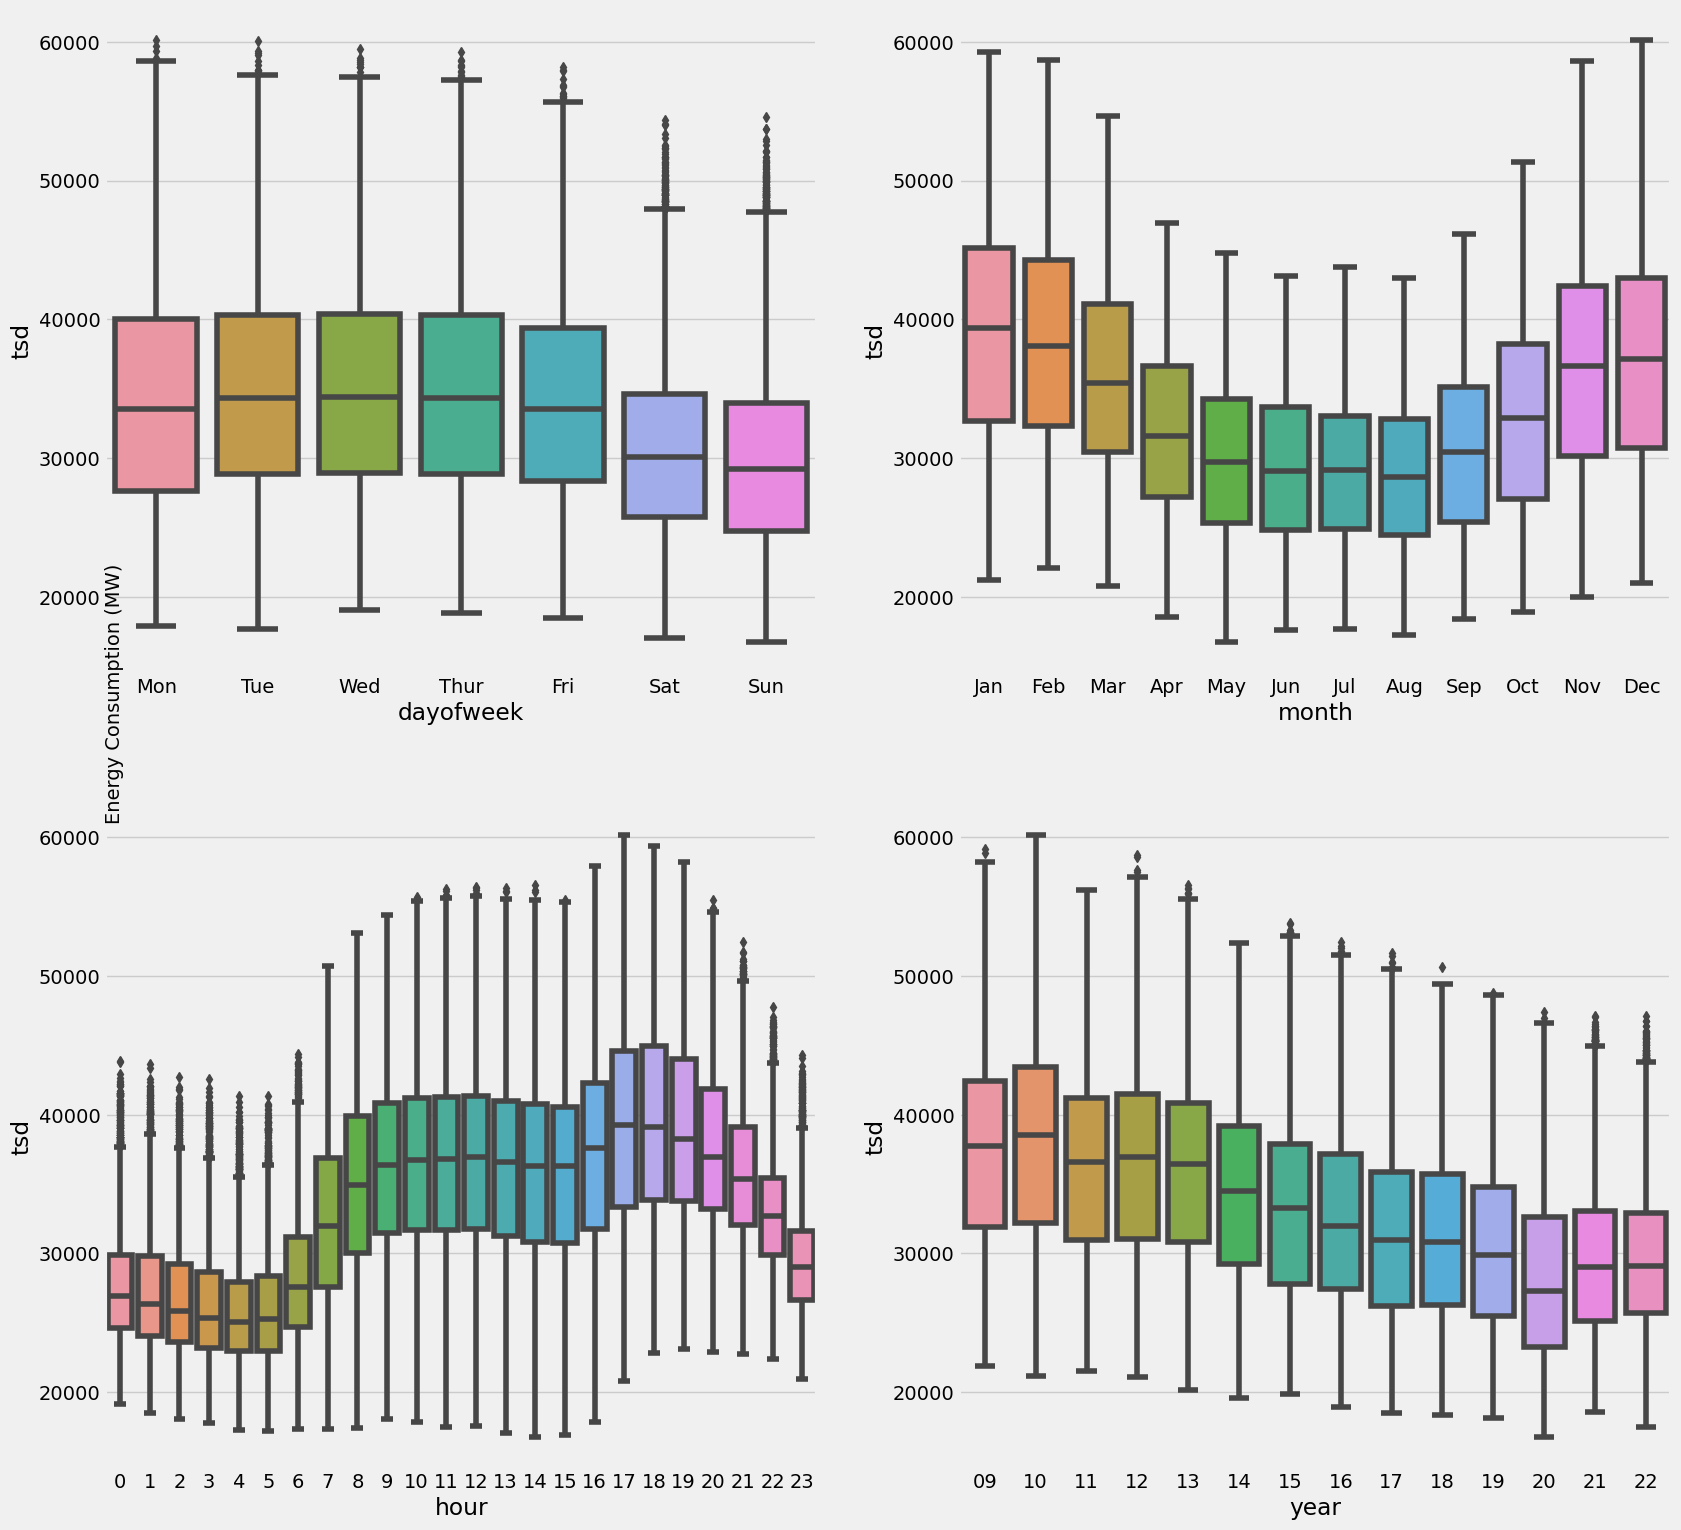

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(18,18))
# Day of Week
days = ['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']
g = sns.boxplot(data=df, x='dayofweek', y='tsd', ax=axes[0][0])
g.set_xticklabels(days)

# Month of Year
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul','Aug','Sep','Oct','Nov','Dec']
g = sns.boxplot(data=df, x='month', y='tsd', ax=axes[0][1])
g.set_xticklabels(months)

# Hour of Day
g = sns.boxplot(data=df, x='hour', y='tsd', ax=axes[1][0])

# Year
years = list(df['year'].astype(str).apply(lambda x : x[2:]).unique())
g = sns.boxplot(data=df, x='year', y='tsd', ax=axes[1][1])
g.set_xticklabels(years)

fig.text(0.08, 0.5, 'Energy Consumption (MW)', va='center', rotation='vertical')
plt.show()

We can see that energy consumption is slightly lower on weekends, probably because business in the U.K. do not operate on weekends. Consumption typically peaks on winter (Nov-Dec-Jan-Feb) and is lower during summer (Jun-July-Aug). Hourly energy consumption is at its lowest around 4 AM. After this time it gradually increases until it plateaus at noon. It then peaks again around 5-6 PM before declining again. A downward trend in mean energy consumption rates and interquartile ranges is observable from year to year.

## Model Creation

Let's create a xgb regressor with some baseline parameters

In [15]:
xgb_model = xgb.XGBRegressor(base_score=0.5,
                       early_stopping_rounds=30,
                       booster='gbtree',    
                       n_estimators=1000,
                       objective='reg:squarederror',
                       max_depth=5,
                       learning_rate=0.01)

Let's separate the training and testing data with the corresponding features and target variable.

In [16]:
features = ['hour','dayofweek', 'quarter', 'month', 'year', 'dayofyear','dayofmonth','lag1','lag2','lag3']
target = 'tsd'

## Time Series Cross Validation

Unlike regular k-fold splits, the idea for time series splits is to divide the training set into two folds on condition that the test set is always ahead of the training split. This way temporal precedence is always respected. 

In the code below we created 5 folds of the data, since we have a hourly data and we want to keep a year of data in the test set, I have set test_size to 24 * 365 * 1. A gap of 24 signifies that the train and test sets would have a gap of 1 day between them.

In [17]:
tss = TimeSeriesSplit(n_splits=3,test_size=24*365*1,gap=24)
df = df.sort_index()

Let's visualize the folds

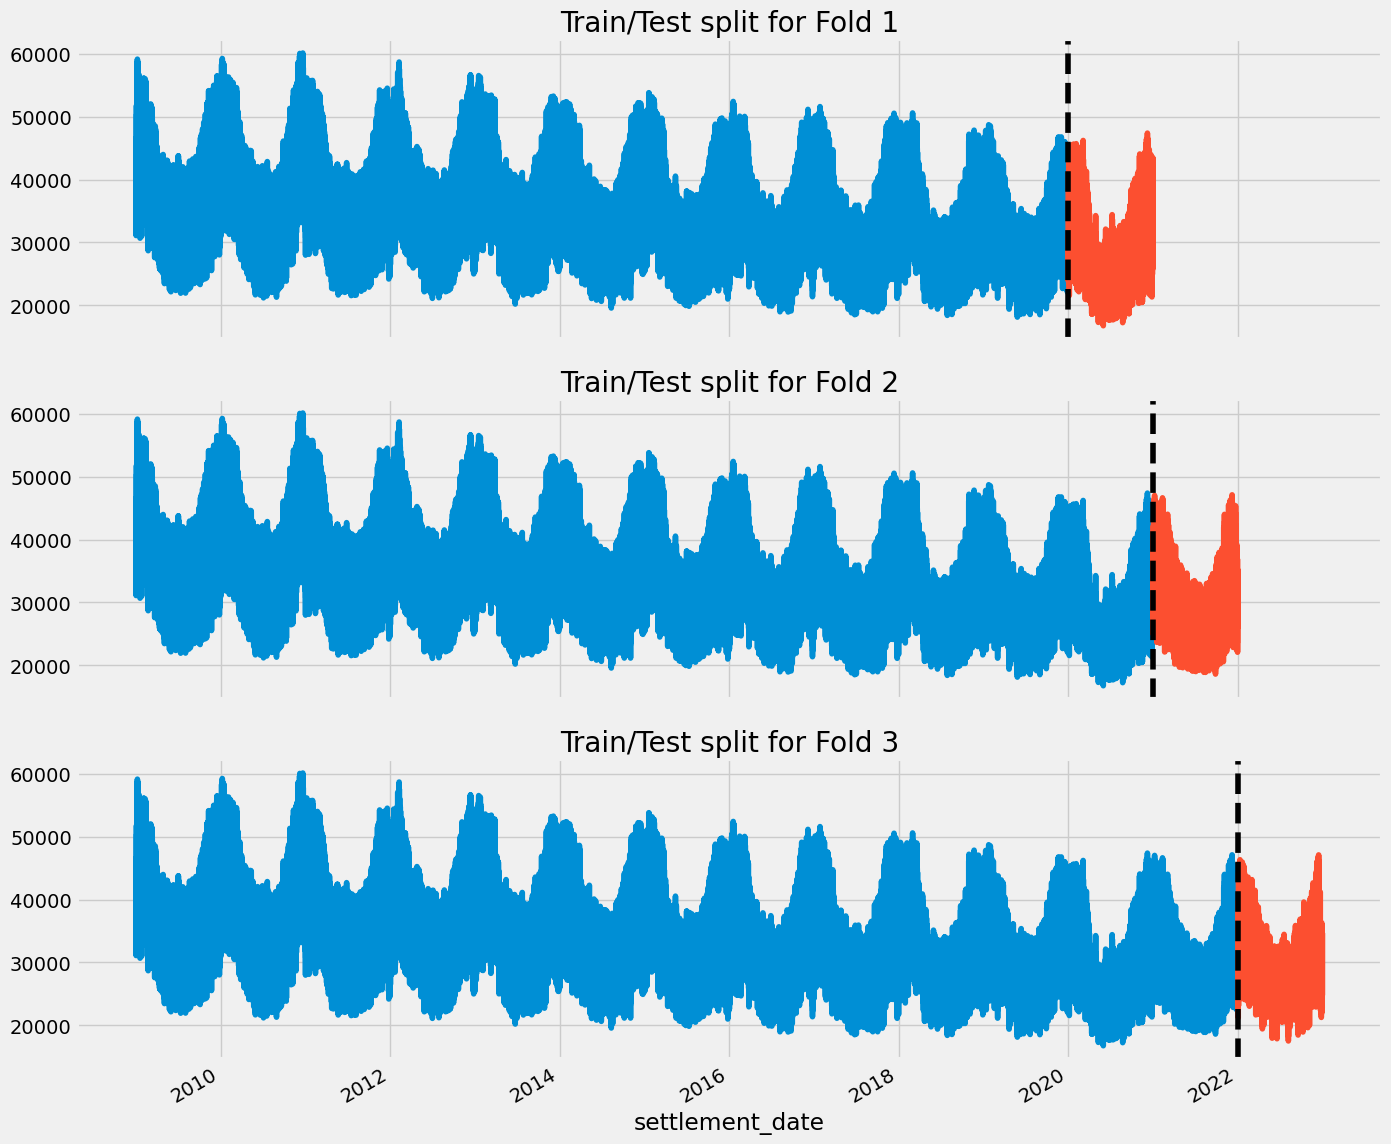

In [18]:
fig,axs = plt.subplots(3,1,figsize=(15,15),sharex=True)

for fold,(train_ind,val_ind) in enumerate(tss.split(df)):
    train = df['tsd'].iloc[train_ind]
    test = df['tsd'].iloc[val_ind]
    train.plot(ax=axs[fold],label='Training Set',title = f'Train/Test split for Fold {fold+1}')
    test.plot(ax=axs[fold],label='Test Set')
    axs[fold].axvline(test.index.min(),color='black',ls='--')
    
plt.show()

Let's train our model in each of the folds and see what the RMSE score behaves across folds.

In [19]:
preds = []
RMSE = []

for train_idx, test_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[test_idx]

    X_train = train[features]
    y_train = train[target]

    X_test = test[features]
    y_test = test[target]

    xgb_model.fit(X_train, y_train,eval_set=[(X_train, y_train), (X_test, y_test)],verbose=100)

    y_pred = xgb_model.predict(X_test)
    preds.append(y_pred)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    RMSE.append(rmse)

[0]	validation_0-rmse:34967.17877	validation_1-rmse:28818.47740
[100]	validation_0-rmse:13027.09844	validation_1-rmse:9816.17537
[200]	validation_0-rmse:5225.01868	validation_1-rmse:3554.16637
[300]	validation_0-rmse:2713.48436	validation_1-rmse:2592.94440
[319]	validation_0-rmse:2510.22884	validation_1-rmse:2621.62948
[0]	validation_0-rmse:34495.74178	validation_1-rmse:29929.53232
[100]	validation_0-rmse:12864.23039	validation_1-rmse:11963.42557
[200]	validation_0-rmse:5188.29038	validation_1-rmse:5779.30028
[300]	validation_0-rmse:2736.10859	validation_1-rmse:3915.28061
[400]	validation_0-rmse:2071.40619	validation_1-rmse:3432.92824
[500]	validation_0-rmse:1860.73008	validation_1-rmse:3308.24941
[600]	validation_0-rmse:1784.19052	validation_1-rmse:3285.64209
[700]	validation_0-rmse:1741.74391	validation_1-rmse:3271.90799
[771]	validation_0-rmse:1715.63900	validation_1-rmse:3277.25375
[0]	validation_0-rmse:34165.83810	validation_1-rmse:29916.60041
[100]	validation_0-rmse:12747.63301	v

In [20]:
print(f'RMSE Score across folds:{np.mean(RMSE):0.2f}')
print(f'Fold scores:{RMSE}')

RMSE Score across folds:2758.51
Fold scores:[2587.1803340726074, 3268.142414128985, 2420.2113242573346]


## Blocked Time Series Cross Validation

The problem with Time Series Splits is that it introduces leakage from future data to the model. The model will observe future patterns to forecast and try to memorize them. That’s why we use blocked cross-validation. It works by making two splits. The first is between the training and validation folds within a fold, in order to prevent the model from observing lag values. The second is between the folds used at each iteration in order to prevent the model from memorizing patterns from an iteration to the next.

This kind of split is not implemented by default in scikit-learn, but we can create any splitter respecting its splitter API.

In [21]:
class BlockTimeSeriesSplit():
    
    def __init__(self, n_splits,test_size,gap):
        self.n_splits = n_splits
        self.test_size = test_size
        self.gap = gap
    
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)

        for i in range(self.n_splits):
            start = i * fold_size
            stop = start + fold_size
            mid = start + int(fold_size - self.test_size)
            yield indices[start:mid], indices[mid + self.gap: stop]

We now apply this new splitter to our dataset and we are going to visualize the folds

In [22]:
btss = BlockTimeSeriesSplit(n_splits=3,test_size=24*365*1,gap=24)
df = df.sort_index()

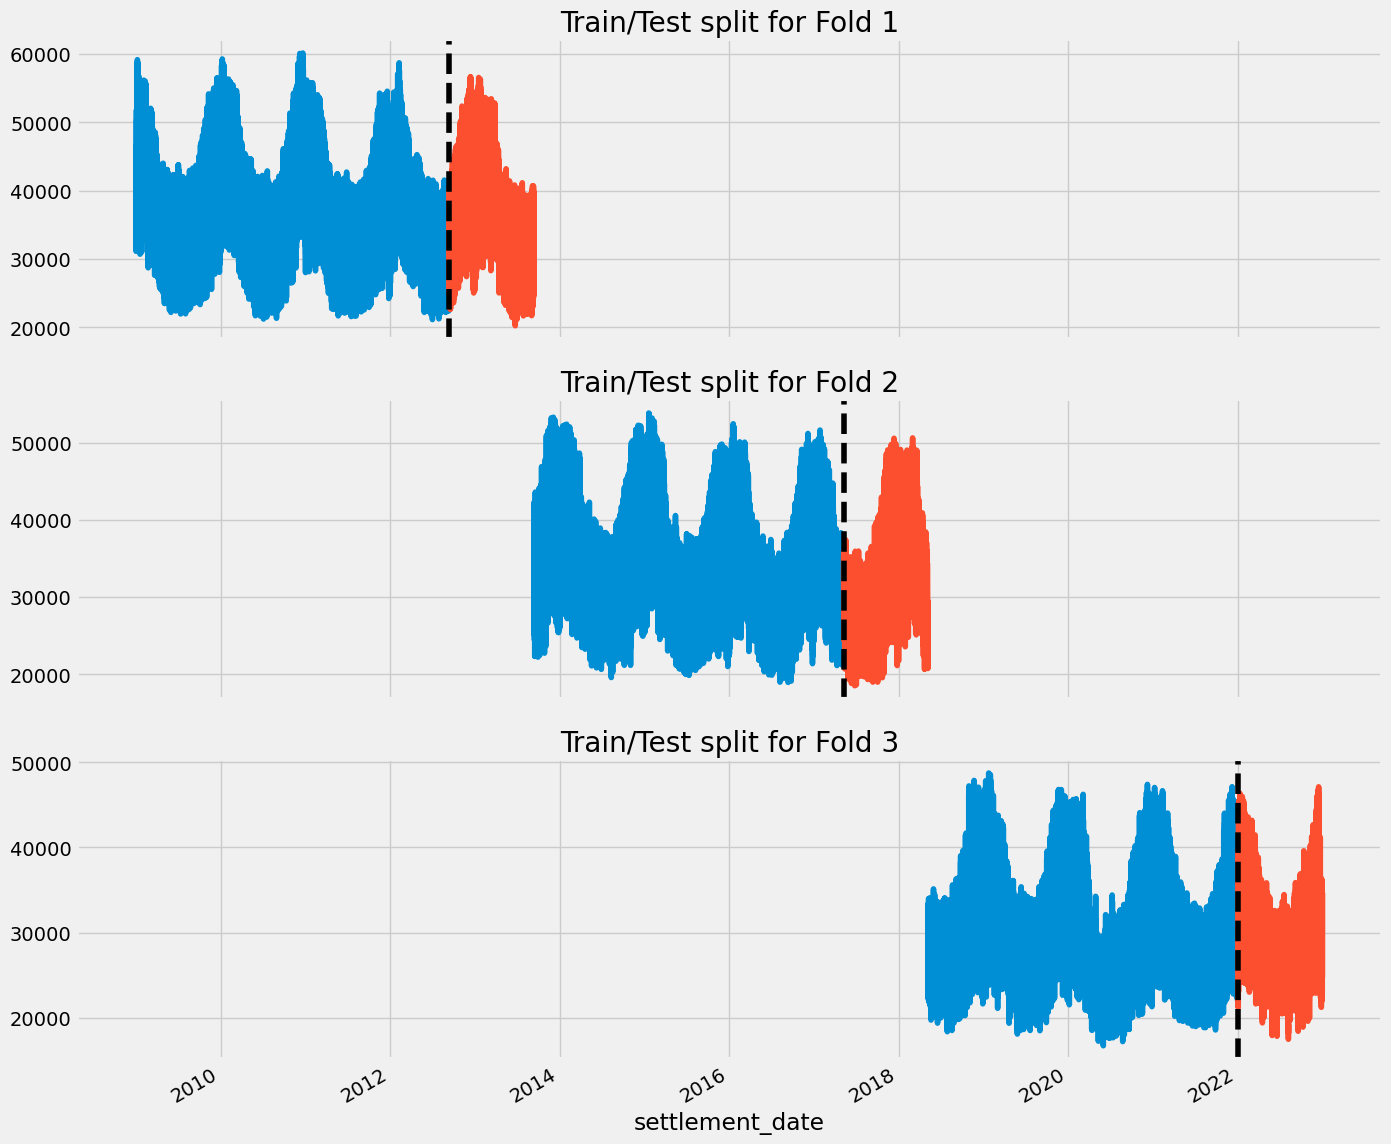

In [23]:
fig,axs = plt.subplots(3,1,figsize=(15,15),sharex=True)

for fold,(train_ind,val_ind) in enumerate(btss.split(df)):
    train = df['tsd'].iloc[train_ind]
    test = df['tsd'].iloc[val_ind]
    train.plot(ax=axs[fold],label='Training Set',title = f'Train/Test split for Fold {fold+1}')
    test.plot(ax=axs[fold],label='Test Set')
    axs[fold].axvline(test.index.min(),color='black',ls='--')
    
plt.show()

Let's train our model using these folds instead.

In [24]:
preds = []
RMSE = []

for train_idx, test_idx in btss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[test_idx]

    X_train = train[features]
    y_train = train[target]

    X_test = test[features]
    y_test = test[target]

    xgb_model.fit(X_train, y_train,eval_set=[(X_train, y_train), (X_test, y_test)],verbose=50)

    y_pred = xgb_model.predict(X_test)
    preds.append(y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    RMSE.append(rmse)

[0]	validation_0-rmse:37603.51951	validation_1-rmse:36966.85635
[50]	validation_0-rmse:22885.43330	validation_1-rmse:22521.87197
[100]	validation_0-rmse:14009.42263	validation_1-rmse:13837.84026
[150]	validation_0-rmse:8681.51098	validation_1-rmse:8665.30539
[200]	validation_0-rmse:5504.72481	validation_1-rmse:5644.04127
[250]	validation_0-rmse:3659.73470	validation_1-rmse:3941.52874
[300]	validation_0-rmse:2625.62866	validation_1-rmse:3026.81543
[350]	validation_0-rmse:2062.74592	validation_1-rmse:2579.64242
[400]	validation_0-rmse:1759.14962	validation_1-rmse:2372.69897
[450]	validation_0-rmse:1582.26012	validation_1-rmse:2299.95144
[500]	validation_0-rmse:1474.24062	validation_1-rmse:2277.27441
[550]	validation_0-rmse:1404.58063	validation_1-rmse:2260.90330
[600]	validation_0-rmse:1359.04969	validation_1-rmse:2244.15479
[650]	validation_0-rmse:1327.76884	validation_1-rmse:2230.61975
[700]	validation_0-rmse:1303.45258	validation_1-rmse:2219.92373
[750]	validation_0-rmse:1282.92585	va

In [25]:
print(f'RMSE Score across folds:{np.mean(RMSE):0.2f}')
print(f'Fold scores:{RMSE}')

RMSE Score across folds:2423.42
Fold scores:[2211.3198288683097, 2492.2125740655997, 2566.7391173283686]


## Outlier detection

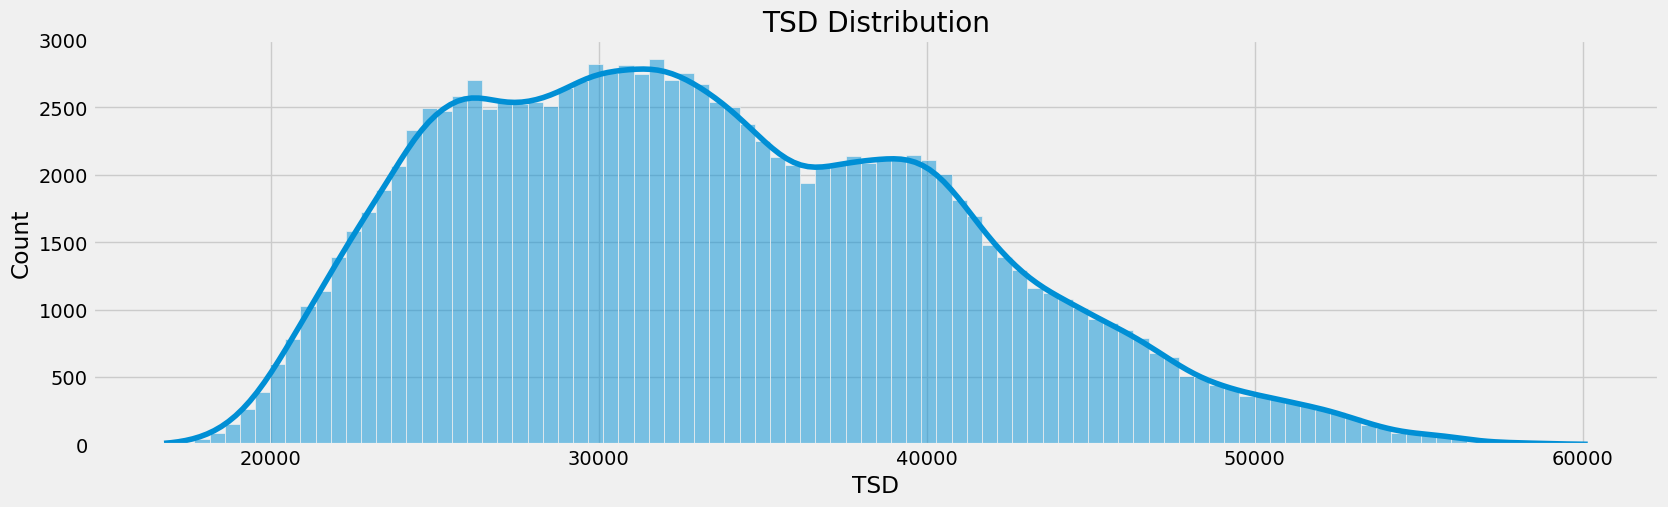

In [26]:
fig, ax = plt.subplots(figsize=(18,5))
g= sns.histplot(x = 'tsd', data = df, kde = True, ax = ax)
g.set_xlabel('TSD')
g.set_ylabel('Count')
ax.set_title('TSD Distribution')
plt.show()

Let's use PyOD for outlier detection and removal. We get 0 for inliers and 1 for outliers. As we are using a single feature to detect outliers our original array must be reshaped.

In [27]:
clf = ECOD()
clf.fit(np.array(df['tsd']).reshape(-1,1))
outliers = clf.predict(np.array(df['tsd']).reshape(-1,1))

We create a new column containing the outlier's labels and remove then from our data

In [28]:
df['outliers'] = pd.DataFrame(outliers,index=df.index)
df_c = df[df['outliers']==0]

Let's see the histogram for the cleaned data

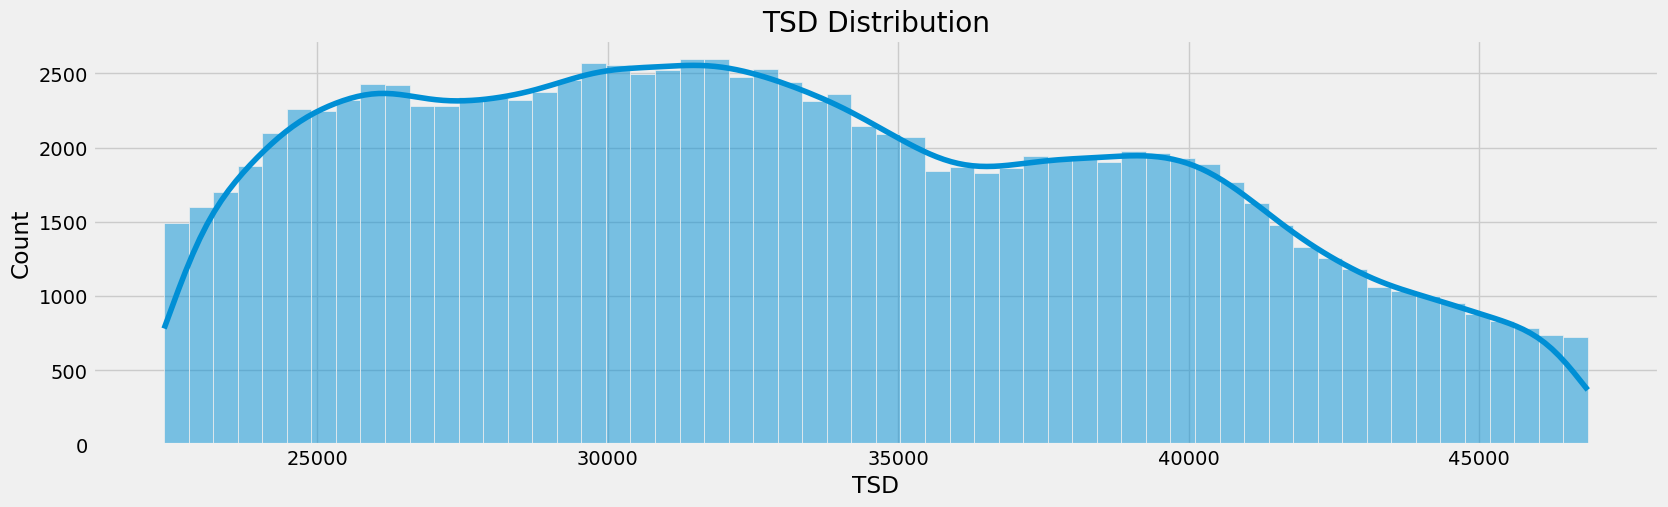

In [29]:
fig, ax = plt.subplots(figsize=(18,5))
g= sns.histplot(x = 'tsd', data = df_c, kde = True, ax = ax)
g.set_xlabel('TSD')
g.set_ylabel('Count')
ax.set_title('TSD Distribution')
plt.show()

## Retrain on all dataset

Let's retrain our model on the whole dataset so we can later use to predict unseen data. From our previous testing we saw that the model plateaus around the 500th iteration, to prevent overfitting the model will only run 220 times.

In [33]:
X_all = df_c[features]
y_all = df_c[target]

xgb_model = xgb.XGBRegressor(base_score=0.5,
                       early_stopping_rounds=30,
                       booster='gbtree',    
                       n_estimators=500,
                       objective='reg:squarederror',
                       max_depth=5,
                       learning_rate=0.01)
xgb_model.fit(X_all, y_all,
              eval_set=[(X_all, y_all)],
              verbose=100)

[0]	validation_0-rmse:33377.52825
[100]	validation_0-rmse:12419.20128
[200]	validation_0-rmse:4989.01392
[300]	validation_0-rmse:2649.48948
[400]	validation_0-rmse:2059.32438
[499]	validation_0-rmse:1887.58800


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=30,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## Forecasting into the future

In [39]:
future = pd.date_range('2023-01-01','2023-12-31',freq='1h')
future_df = pd.DataFrame(index=future)

Because we have lag features we want to concatenate this future dataframe to the end of our training dataset.

In [40]:
future_df['isFuture']=True
df['isFuture']= False
df_and_future = pd.concat([df,future_df])

In [41]:
df_and_future = create_datetime_feat(df_and_future)
df_and_future = create_lag_feat(df_and_future)

Now let's extract the future dataframe with the datetime and lags features

In [42]:
df_future_with_feat = df_and_future.query('isFuture').copy()
df_future_with_feat

In [44]:
X_fut = df_future_with_feat[features]

In [45]:
df_future_with_feat['prediction'] = xgb_model.predict(X_fut)

Let's plot the future now

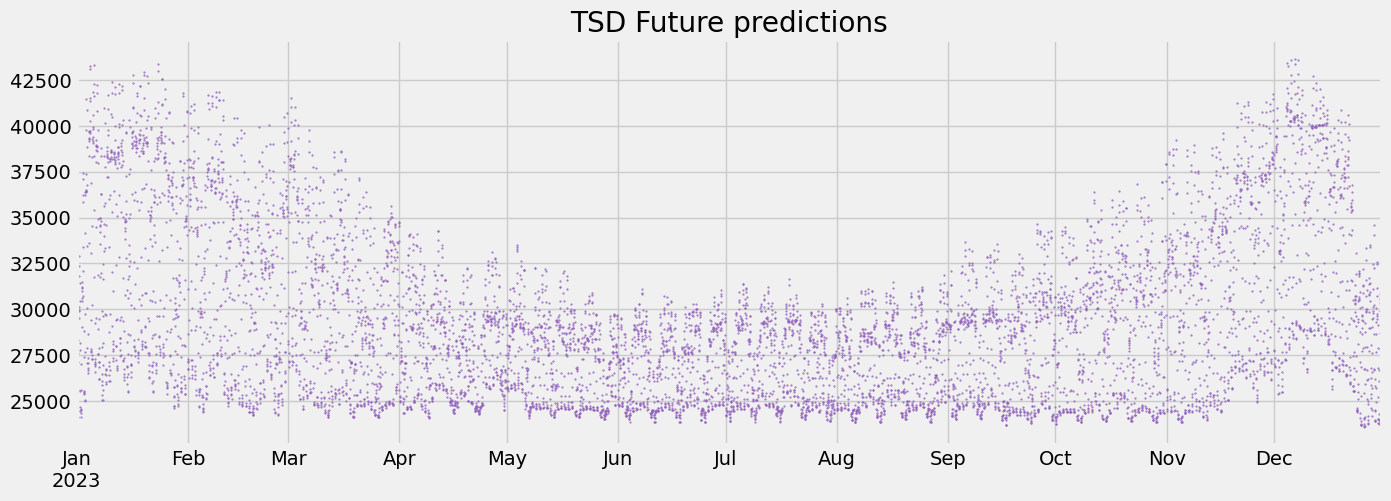

In [48]:
df_future_with_feat['prediction'] .plot(style='.',figsize=(15,5),title='TSD Future predictions',ms=1,lw=1,color=color_pal[4])
plt.show()